In [ ]:
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0000_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0002_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0014_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0017_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0031_processed.tfrecord

!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0036_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0043_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0046_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0057_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0060_processed.tfrecord

!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0067_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0086_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0090_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0091_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0111_processed.tfrecord

!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0112_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0123_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0130_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0131_processed.tfrecord
!wget https://cs230-project.s3.us-east-2.amazonaws.com/train0133_processed.tfrecord

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
files = ['0000', '0002', '0014', '0017', '0031', 
         '0036', '0043', '0046', '0057', '0060', 
         '0067', '0086', '0090', '0091', '0111', 
         '0112', '0123', '0130', '0131', '0133']

In [4]:
def read_dataset(file_path):
    dataset = tf.data.TFRecordDataset(file_path)

    def read_tfrecord(serialized_example):
        feature_description = {
            'thumbnail': tf.io.VarLenFeature(tf.string),
            'n_W': tf.io.FixedLenFeature((), tf.int64),
            'n_H': tf.io.FixedLenFeature((), tf.int64),
            'n_C': tf.io.FixedLenFeature((), tf.int64),
            'labels': tf.io.VarLenFeature(tf.int64),
        }
        example = tf.io.parse_single_example(serialized_example, feature_description)
        return example

    parsed_dataset = dataset.map(read_tfrecord)
    return parsed_dataset


def labeled_dataset(parsed_dataset):
    labeled_data_sets = []

    for example in parsed_dataset:
        thumbnail_bytes = example["thumbnail"].values[0].numpy()
        n_W = example["n_W"].numpy()
        n_C = example["n_C"].numpy()
        n_H = example["n_H"].numpy()

        thumbnail_arr = np.frombuffer(thumbnail_bytes, dtype=np.uint8).reshape((n_W, n_H, n_C))
        labels = example["labels"].values[0].numpy() 

        labeled_dataset = [thumbnail_arr, labels]
        labeled_data_sets.append(labeled_dataset)
    return labeled_data_sets

In [5]:
x = []
y = []
counter = [0] * 4
for number in files:
  parsed_dataset = read_dataset('/content/train' + number + '_processed.tfrecord') # ACTION NEEDED: .tfrecord file_path needs to be specified
  labeled_data_sets = labeled_dataset(parsed_dataset)
  for data in labeled_data_sets:
    if data[1] == 12:
      val = 0
    elif data[1] == 11:
      val = 1
    elif data[1] == 17:
      val = 2
    else:
      val = 3
    if counter[val] < 1000:
      resized_image = cv2.resize(data[0], (224, 224)) / 255.0
      x.append(resized_image)
      y.append(val)
      counter[val] += 1
  if counter[0] == counter[1] == counter[2] == counter[3] == 500:
    break

In [6]:
new_y = np.array(y).T
new_x = np.array(x)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3200, 224, 224, 3)
(3200, 4)
(800, 224, 224, 3)
(800, 4)


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
checkpoint = ModelCheckpoint("vgg16.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[checkpoint, early])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.2339 - accuracy: 0.4403
Epoch 00001: val_accuracy improved from -inf to 0.53625, saving model to vgg16.h5
100/100 [==============================] - 21s 98ms/step - loss: 1.2339 - accuracy: 0.4403 - val_loss: 1.1265 - val_accuracy: 0.5362
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.9785 - accuracy: 0.6025
Epoch 00002: val_accuracy improved from 0.53625 to 0.56000, saving model to vgg16.h5
100/100 [==============================] - 9s 92ms/step - loss: 0.9785 - accuracy: 0.6025 - val_loss: 1.0938 - val_accuracy: 0.5600
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.8676 - accuracy: 0.6597
Epoch 00003: val_accuracy improved from 0.56000 to 0.58750, saving model to vgg16.h5
100/100 [==============================] - 9s 91ms/step - loss: 0.8676 - accuracy: 0.6597 - val_loss: 1.0437 - val_accuracy: 0.5875
Epoch 4/100
100/100 [==============================] - ETA: 

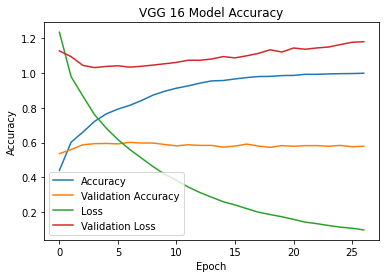

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history["loss"])
plt.plot(hist.history['val_loss'])
plt.title("VGG 16 Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()
plt.savefig('vgg16_acc.png')

In [20]:
from keras.models import load_model
saved_model = load_model("vgg16.h5")
test_x = []
original_y = []
parsed_dataset = read_dataset('/content/train0133_processed.tfrecord') # ACTION NEEDED: .tfrecord file_path needs to be specified
labeled_data_sets = labeled_dataset(parsed_dataset)
for data in labeled_data_sets[:800]:
  if data[1] == 12:
    val = 0
  elif data[1] == 11:
    val = 1
  elif data[1] == 17:
    val = 2
  else:
    val = 3
  resized_image = cv2.resize(data[0], (224, 224)) / 255.0
  test_x.append(resized_image)
  original_y.append(val)
test_y = np.array(original_y).T
test_x = np.array(test_x)
test_y = to_categorical(test_y)
loss, acc = saved_model.evaluate(test_x, test_y)
print(loss)
print(acc)

25/25 [==============================] - 2s 65ms/step - loss: 0.9754 - accuracy: 0.5938
0.9753575325012207
0.59375


In [30]:
predict_y = saved_model.predict(test_x)
predict_y = np.argmax(predict_y, axis=1)
original_y = np.array(original_y)

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
precision = precision_score(original_y, predict_y, average='macro')
recall = recall_score(original_y, predict_y, average='macro')
f1 = f1_score(original_y, predict_y, average='macro')
cm = confusion_matrix(original_y, predict_y)
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')
print(cm)

Precision score is: 0.5706507824403878
Recall score is: 0.6175184906213058
F1 score is: 0.5728541664622285
[[203  35  19  33]
 [ 28 131  14  17]
 [  6   7  65   8]
 [ 60  39  59  76]]


In [58]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

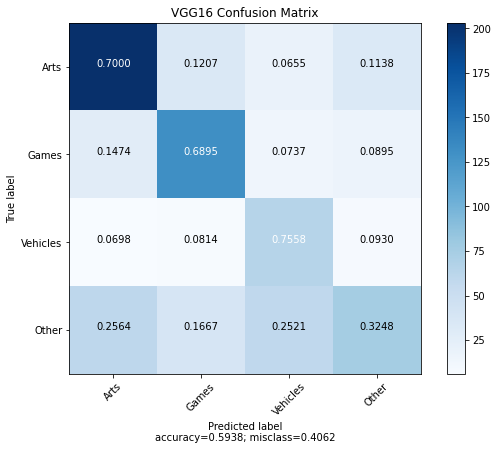

<Figure size 432x288 with 0 Axes>

In [57]:
plot_confusion_matrix(cm, ['Arts', 'Games', 'Vehicles', 'Other'], title='VGG16 Confusion Matrix')